<img src="https://raw.githubusercontent.com/EO-College/cubes-and-clouds/main/icons/cnc_icon_process.svg"
     alt="Cubes & Clouds Processing logo" width="00"
     style="width: 800px; height:400px; float: center; margin-right: 10px;" />

# 3.1 Data Processing
In this exercise we will build a complete EO workflow on a cloud platform; from data access to obtaining the result. In this example we will analyse snow cover in the Alps.

We are going to follow these steps in our analysis:

-   Load satellite collections
-   Specify the spatial, temporal extents and the features we are interested in
-   Process the satellite data to retrieve snow cover information
-   aggregate information in data cubes
-   Visualize and analyse the results

More information on the openEO Python Client: https://open-eo.github.io/openeo-python-client/index.html

## Libraries

In [ ]:
pip install openeo rioxarray geopandas leafmap h5netcdf netcdf4

In [2]:
# platform libraries
import openeo

# utility libraries
from datetime import date
import numpy as np
import xarray as xr
import rioxarray
import json
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import leafmap.foliumap as leafmap

## Login
Connect to the copernicus dataspace ecosystem.

In [3]:
conn = openeo.connect('https://openeo.dataspace.copernicus.eu/')

And login

In [4]:
conn.authenticate_oidc()

Authenticated using refresh token.


<Connection to 'https://openeo.dataspace.copernicus.eu/openeo/1.1/' with OidcBearerAuth>

Check if the login worked.

In [ ]:
conn.describe_account()

## Region of Interest

Load the catchment area.

In [6]:
catchment_outline = gpd.read_file('data/catchment_outline.geojson')

In [7]:
center = (float(catchment_outline.centroid.y), float(catchment_outline.centroid.x))
m = leafmap.Map(center=center, zoom=10)
m.add_vector('data/catchment_outline.geojson', layer_name="catchment")
m

## Inspect Metadata
We need to set the following configurations to define the content of the data cube we want to access:
- dataset name
- band names
- time range
- the area of interest specifed via bounding box coordinates
- spatial resolution

To select the correct dataset we can first list all the available datasets.

In [8]:
print(conn.list_collection_ids())

['SENTINEL3_OLCI_L1B', 'SENTINEL3_SLSTR', 'SENTINEL_5P_L2', 'SENTINEL2_L1C', 'SENTINEL2_L2A', 'SENTINEL1_GRD', 'COPERNICUS_30']


We want to use the Sentinel-2 L2A product. It's name is `'SENTINEL2_L2A'`. 

We get the metadata for this collection as follows.

In [9]:
conn.describe_collection("SENTINEL2_L2A")

{'assets': {'thumbnail': {'href': 'https://www.esa.int/var/esa/storage/images/esa_multimedia/images/2022/07/tallinn_estonia/24383281-1-eng-GB/Tallinn_Estonia_pillars.jpg',
   'roles': ['thumbnail'],
   'title': 'Sentinel 2 L2A',
   'type': 'image/png'}},
 'cube:dimensions': {'bands': {'type': 'bands',
   'values': ['B01',
    'B02',
    'B03',
    'B04',
    'B05',
    'B06',
    'B07',
    'B08',
    'B8A',
    'B09',
    'B11',
    'B12',
    'WVP',
    'AOT',
    'SCL',
    'sunAzimuthAngles',
    'sunZenithAngles',
    'viewAzimuthMean',
    'viewZenithMean']},
  't': {'extent': ['2015-07-04T00:00:00Z', None], 'type': 'temporal'},
  'x': {'axis': 'x',
   'extent': [-180, 180],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'},
  'y': {'axis': 'y',
   'extent': [-56, 83],
   'reference_system': {'$schema': 'https://proj.org/schemas/v0.2/projjson.schema.json',
    'area': 'World',
    'bbox': {'east_longitude': 180,
     'north_latitude': 90,
     'south_latitude': -90,
     'west_longitude': -180},
    'coordinate_system': {'axis': [{'abbreviation': 'Lat',
       'direction': 'north',
       'name': 'Geodetic latitude',
       'unit': 'degree'},
      {'abbreviation': 'Lon',
       'direction': 'east',
       'name': 'Geodetic longitude',
       'unit': 'degree'}],
     'subtype': 'ellipsoidal'},
    'datum': {'ellipsoid': {'inverse_flattening': 298.257223563,
      'name': 'WGS 84',
      'semi_major_axis': 6378137},
     'name': 'World Geodetic System 1984',
     'type': 'GeodeticReferenceFrame'},
    'id': {'authority': 'OGC', 'code': 'Auto42001', 'version': '1.3'},
    'name': 'AUTO 42001 (Universal Transverse Mercator)',
    'type': 'GeodeticCRS'},
   'step': 10,
   'type': 'spatial'}},
 'description': 'SENTINEL-2 is a wide-swath, high-resolution, multi-spectral imaging mission, supporting Copernicus Land Monitoring studies, including the monitoring of vegetation, soil and water cover, as well as observation of inland waterways and coastal areas. The SENTINEL-2 Multispectral Instrument (MSI) samples 13 spectral bands: four bands at 10 metres, six bands at 20 metres and three bands at 60 metres spatial resolution.\n The level 2A data is atmospherically corrected using Sen2Cor.',
 'extent': {'spatial': {'bbox': [[-180, -56, 180, 83]]},
  'temporal': {'interval': [['2015-07-04T00:00:00Z', None]]}},
 'id': 'SENTINEL2_L2A',
 'keywords': ['COPERNICUS',
  'ESA',
  'Orthoimagery',
  'Sentinel-2',
  'MSI',
  'Level-2A',
  'Radiometry',
  'Plant Resource',
  'TOC'],
 'license': 'proprietary',
 'links': [{'href': 'https://sentinels.copernicus.eu/documents/247904/690755/Sentinel_Data_Legal_Notice',
   'rel': 'license',
   'type': 'application/pdf'},
  {'href': 'https://documentation.dataspace.copernicus.eu/Data/Sentinel2.html',
   'rel': 'alternate',
   'type': 'application/html'},
  {'href': 'https://dataspace.copernicus.eu/browser/?zoom=11&lat=45.36638&lng=12.49832&themeId=DEFAULT-THEME&visualizationUrl=https%3A%2F%2Fsh.dataspace.copernicus.eu%2Fogc%2Fwms%2F28b654e7-8912-4e59-9e58-85b58d768b3a&datasetId=S2_L2A_CDAS&fromTime=2023-02-07T00%3A00%3A00.000Z&toTime=

## Define a workflow
We will define our workflow now. And chain all the processes together we need for analyzing the snow cover in the catchment.

### Define the data cube
We define all extents of our data cube. We use the catchment as spatial extent. As a time range we will focus on the snow melting season 2018, in particular from Febraury to June 2018.

In [10]:
bbox = catchment_outline.bounds.iloc[0]
bbox

minx    11.020833
miny    46.653599
maxx    11.366667
maxy    46.954167
Name: 0, dtype: float64

In [11]:
from openeo.processes import lte
collection      = 'SENTINEL2_L2A'
spatial_extent  = {'west':bbox[0],'east':bbox[2],'south':bbox[1],'north':bbox[3],'crs':4326}
temporal_extent = ["2018-02-01", "2018-06-30"]
bands           = ['B03', 'B11', 'SCL']
# properties={"eo:cloud_cover": lambda x: lte(x, 50)})

### Load the data cube
We have defined the extents we are interested in. Now we use these definitions to load the data cube.

In [12]:
s2 = conn.load_collection(collection,
                          spatial_extent=spatial_extent,
                          bands=bands,
                          temporal_extent=temporal_extent)
                         # properties=properties)

### NDSI - Normalized Difference Snow Index
The Normalized Difference Snow Index (NDSI) is computed as:

$$ NDSI = \frac {GREEN - SWIR} {GREEN +SWIR} $$

We have created a Sentinel-2 data cube with bands B03 (green), B11 (SWIR) and the cloud mask (CLM). We will use the green and SWIR band to calculate a the NDSI. This process is reducing the band dimension of the data cube to generate new information, the NDSI.

In [13]:
green = s2.band("B03")
swir = s2.band("B11")
ndsi = (green - swir) / (green + swir)
ndsi

### Creating the Snow Map
So far we have a timeseries of NDSI values. We are intereseted in the presence of snow though. Ideally in a binary classification: snow and no snow.
To achieve this we are setting a threshold of 0.4 on the NDSI. This gives us a binary snow map.

In [14]:
snowmap = ( ndsi > 0.4 ) * 1.0
snowmap

### Creating a cloud mask
We are going to use "SCL" band for creating a cloud mask and then applying it to the NDSI. 
`8 = cloud medium probability`, `9 = cloud high probability`, `3 = cloud shadow`

Here is more information on the Scene Classification https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm-overview

| Value        | Label    |
|--------------|-----------|
| 0	    | NO_DATA                  |
| 1	    | SATURATED_OR_DEFECTIVE   |
| 2	    | CAST_SHADOWS             |
| 3	    | CLOUD_SHADOWS            |
| 4	    | VEGETATION               |
| 5	    | NOT_VEGETATED            |
| 6	    | WATER 	    	       |
| 7	    | UNCLASSIFIED 	           |
| 8	    | CLOUD_MEDIUM_PROBABILITY |
| 9	    | CLOUD_HIGH_PROBABILITY   |
| 10	| THIN_CIRRUS              |
| 11	| SNOW or ICE              |

In [15]:
scl_band = s2.band("SCL")
cloud_mask = ( (scl_band == 8) | (scl_band == 9) | (scl_band == 3) ) * 1.0
cloud_mask

### Applying the cloud mask to the snowmap
We will mask out all pixels that are covered by clouds. This will result in: 0 = no_snow, 1 = snow, 2 = cloud

In [16]:
snowmap_cloudfree = snowmap.mask(cloud_mask,replacement=2) # replacement is null by default
snowmap_cloudfree

### Mask Polygon: From Bounding Box to Shape
Filter to the exact outline of the catchment: this should mask out the pixels outside of the catchment.

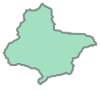

In [17]:
catchment_outline['geometry'][0]

In [18]:
snowmap_cloudfree_masked = snowmap_cloudfree.mask_polygon(catchment_outline['geometry'][0])

#### Visualize one time step of the timeseries
Let's donwload the whole image time series as a netcdf file to have a look how our first results look like

In [19]:
conn.list_file_formats()

{'input': {'GTiff': {'description': 'Geotiff is one of the most widely supported formats. This backend allows reading from Geotiff to create raster data cubes.',
   'gis_data_types': ['raster'],
   'parameters': {}},
  'GeoJSON': {'description': 'GeoJSON allows sending vector data as part of your JSON request. GeoJSON is always in EPSG:4326. ',
   'gis_data_types': ['vector'],
   'parameters': {}},
  'Parquet': {'description': 'GeoParquet is an efficient binary format, to distribute large amounts of vector data.',
   'gis_data_types': ['vector'],
   'parameters': {}}},
 'output': {'CSV': {'description': 'CSV format is supported to export vector cube data, for instance generated by aggregate_spatial.',
   'gis_data_types': ['vector'],
   'parameters': {},
   'title': 'Comma Separated Values'},
  'CovJSON': {'gis_data_types': ['other', 'raster'],
   'parameters': {},
   'title': 'CoverageJSON'},
  'GTiff': {'description': 'Cloud Optimized Geotiff is one of the most widely supported formats and thus a popular choice for further dissemination. This implementation stores all bands in one file, and creates one file per timestamp in your datacube.',
   'gis_data_types': ['raster'],
   'parameters': {'ZLEVEL': {'default': '6',
     'description': 'Specifies the compression level used for DEFLATE compression. As a number from 1 to 9, lowest and fastest compression is 1 while 9 is highest and slowest compression.',
     'type': 'string'},
    'colormap': {'default': None,
     'description': 'Allows specifying a colormap, for single band geotiffs. The colormap is a dictionary mapping band values to colors, specified by an integer.',
     'type': ['object', 'null']},
    'feature_id_property': {'default': None,
     'description': 'Specifies the name of the feature attribute that is to be used as feature id, by processes that require it. Can be used to link a given output back to an input feature.',
     'type': ['string', 'null']},
    'filename_prefix': {'default': None,
     'description': "Specifies the filename prefix when outputting multiple files. By default, depending on the context, 'OpenEO' or a part of the input filename will be used as prefix.",
     'type': 'string'},
    'overviews': {'default': 'AUTO',
     'description': 'Specifies the strategy to generate overviews. The default, AUTO, allows the backend to choose an optimal configuration, depending on the size of the generated tiff, and backend capabilities.',
     'enum': ['AUTO', 'OFF'],
     'type': 'string'},
    'sample_by_feature': {'default': False,
     'description': 'Set to true to write one output tiff per feature and date. Spatial features can be specified using filter_spatial. This setting is used to sample a data cube at multiple locations in a single job.',
     'type': 'boolean'},
    'tile_grid': {'default': None,
     'description': 'Specifies the tile grid to use, for batch jobs only. By default, no tile grid is set, and one Geotiff is generated per date. If a tile grid is set, multiple geotiffs are generated per date, as defined by the specified tiling grid.',
     'enum': ['wgs84-1degree', 'utm-100km', 'utm-20km', 'utm-10km'],
     'type': ['string', 'null']}},
   'title': 'GeoTiff'},
  'JSON': {'gis_data_types': ['raster', 'vector'], 'parameters': {}},
  'PNG': {'gis_data_types': ['raster'],
   'parameters': {'colormap': {'default': None,
     'description': 'Allows specifying a colormap, for single band PNGs. The colormap is a dictionary mapping band values to colors, either specified by an integer or an array of [R, G, B, A], where each value lies between 0.0 and 1.0.',
     'type': ['object', 'null']}},
   'title': 'Portable Network Graphics'},
  'netCDF': {'description': 'netCDF files allow to accurately represent an openEO datacube and its metadata.',
   'gis_data_types': ['other', 'raster'],
   'parameters': {'feature_id_property': {'default': None,
     'description': 'Specifies the name of the feature attribute that is to be used as feature 

In [20]:
snowmap_cloudfree_1d = snowmap_cloudfree_masked.filter_temporal('2018-02-10', '2018-02-12')
snowmap_cloudfree_1d.download('data/snowmap_cloudfree_1d.nc')

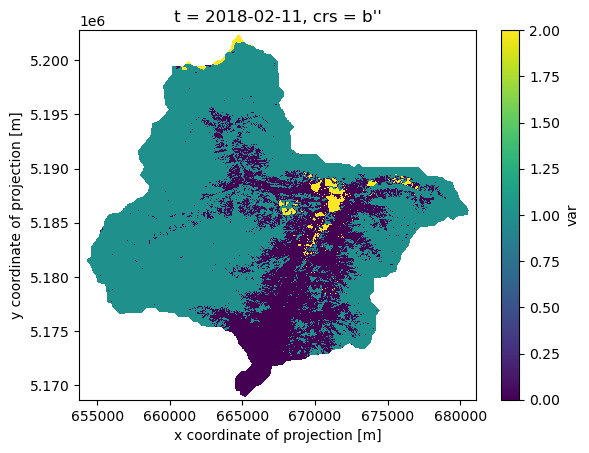

In [21]:
xr.open_dataarray('data/snowmap_cloudfree_1d.nc',decode_coords="all")[0].plot.imshow()

## Calculate Catchment Statistics

We are looking at a region over time. We need to make sure that the information content meets our expected quality. Therefore, we calculate the **cloud percentage** for the catchment for each timestep. We use this information to filter the timeseries. All timesteps that have a cloud coverage of over 25% will be discarded.

Ultimately we are interested in the **snow covered area (SCA)** within the catchment. We count all snow covered pixels within the catchment for each time step. Multiplied by the pixel size that would be the snow covered area. Divided the pixel count by the total number of pixels in the catchment is the percentage of pixels covered with snow. We will use this number.

Get number of pixels in catchment: total, clouds, snow.

In [53]:
# number of all pixels
n_catchment = ((snowmap_cloudfree > -1) * 1.0).add_dimension(name="bands",type="bands",label="n_catchment")

# number of cloud pixels (no function needed, mask already created before)
n_cloud = cloud_mask.add_dimension(name="bands",type="bands",label="n_cloud")

# number of snow pixels
n_snow = ((snowmap_cloudfree == 1) * 1.0).add_dimension(name="bands",type="bands",label="n_snow")

# combine the binary data cubes into one data cube
n_catchment_cloud_snow = n_catchment.merge_cubes(n_cloud).merge_cubes(n_snow)

# aggregate to catchment
n_pixels = n_catchment_cloud_snow.aggregate_spatial(geometries = catchment_outline['geometry'][0], reducer = 'sum')
n_pixels

Create batch job to start processing on the backend.

In [54]:
# Create a batch job
n_pixels_json = n_pixels.save_result(format="JSON")
job = n_pixels_json.create_job(title="n_pixels_json")
job.start_job()

In [55]:
job

<BatchJob job_id='j-2ccefd4a7521437681c683e13844b1a9'>

In [62]:
job.status()

'finished'

In [61]:
if job.status() == "finished":
    results = job.get_results()
    results.download_files("data/")

Load the result. It contains the number of pixels in the catchment, clouds and snow.

We can calculate the percentages of cloud and snow pixels in the catchment.

In [63]:
with open("data/timeseries.json","r") as file:
    n_pixels_json = json.load(file)

In [64]:
# check the first 5 entries
list(n_pixels_json.items())[:3] # careful unsorted dates due to JSON format

[('2018-02-16T00:00:00Z', [[4201607.0, 1809140.0, 1479720.0]]),
 ('2018-03-13T00:00:00Z', [[4201607.0, 2623118.0, 1529006.0]]),
 ('2018-03-10T00:00:00Z', [[4201607.0, 4201607.0, 0.0]])]

In [65]:
# Create a Pandas DataFrame to contain the values
dates = [k for k in n_pixels_json]
n_catchment_vals = [n_pixels_json[k][0][0] for k in n_pixels_json]
n_cloud_vals = [n_pixels_json[k][0][1] for k in n_pixels_json]
n_snow_vals = [n_pixels_json[k][0][2] for k in n_pixels_json]

data = {
        "time":pd.to_datetime(dates),
        "n_catchment_vals":n_catchment_vals,
        "n_cloud_vals":n_cloud_vals,
        "n_snow_vals":n_snow_vals
       }
df = pd.DataFrame(data=data).set_index("time")
# Sort the values by date
df = df.sort_values(axis=0,by="time")
df[:3]

,n_catchment_vals,n_cloud_vals,n_snow_vals
time,,,
2018-02-01 00:00:00+00:00,4201607.0,4196050.0,1120.0
2018-02-03 00:00:00+00:00,4201607.0,3921067.0,220205.0
2018-02-06 00:00:00+00:00,4201607.0,2575183.0,1493282.0


Divide the number of cloudy pixels by the number of total pixels = cloud percentage

In [66]:
perc_cloud = df["n_cloud_vals"].values / df["n_catchment_vals"].values * 100
df["perc_cloud"] = perc_cloud
df[:3]

,n_catchment_vals,n_cloud_vals,n_snow_vals,perc_cloud
time,,,,
2018-02-01 00:00:00+00:00,4201607.0,4196050.0,1120.0,99.867741
2018-02-03 00:00:00+00:00,4201607.0,3921067.0,220205.0,93.323031
2018-02-06 00:00:00+00:00,4201607.0,2575183.0,1493282.0,61.290430


Plot the timeseries and the cloud threshold of 25%. If the cloud cover is higher the timestep will be excluded later on.

Plot the **cloud percentage** with the threshold.

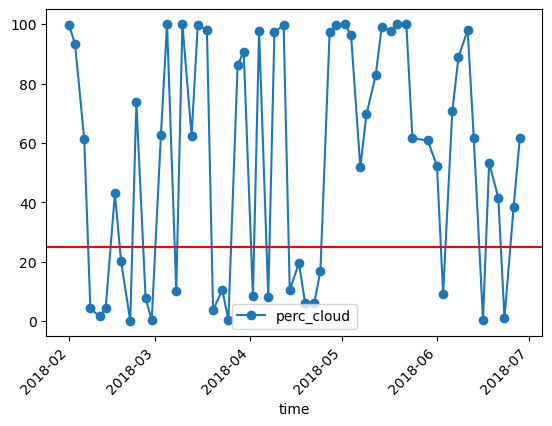

In [67]:
df.plot(y="perc_cloud",rot=45,kind="line",marker='o')
plt.axhline(y = 25, color = "r", linestyle = "-")
plt.show()

Divide the number of snow pixels by the number of total pixels = snow percentage

In [68]:
perc_snow = df["n_snow_vals"].values / df["n_catchment_vals"].values * 100
df["perc_snow"] = perc_snow
df[:3]

,n_catchment_vals,n_cloud_vals,n_snow_vals,perc_cloud,perc_snow
time,,,,,
2018-02-01 00:00:00+00:00,4201607.0,4196050.0,1120.0,99.867741,0.026656
2018-02-03 00:00:00+00:00,4201607.0,3921067.0,220205.0,93.323031,5.240971
2018-02-06 00:00:00+00:00,4201607.0,2575183.0,1493282.0,61.290430,35.540735


Plot the **unfiltered snow percentage**

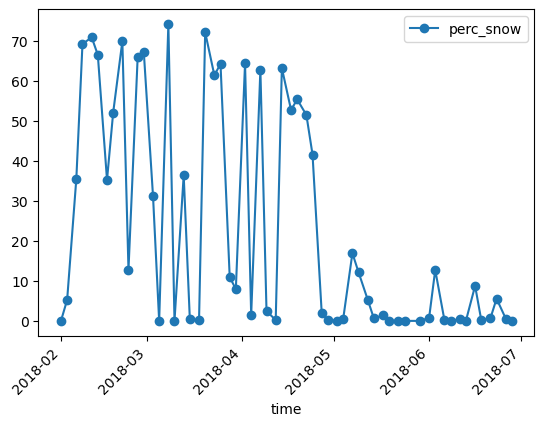

In [69]:
df.plot(y="perc_snow",rot=45,kind="line",marker='o')
plt.show()

Keep only the dates with cloud coverage less than the threshold

In [70]:
df_filtered = df.loc[df["perc_cloud"]<25]

Plot the **cloud filtered snow percentage**

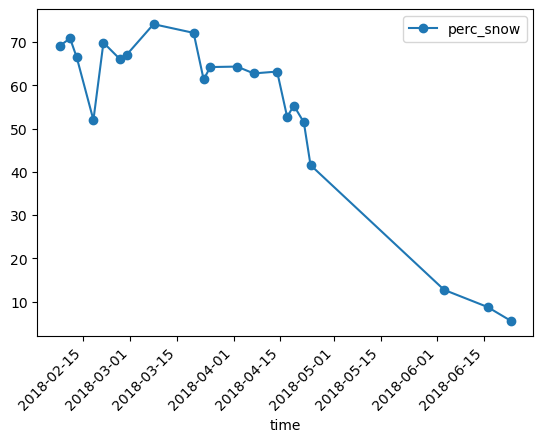

In [71]:
df_filtered.plot(y="perc_snow",rot=45,kind="line",marker='o')
plt.show()

Save the **cloud filtered snow percentage**

In [72]:
df_filtered.to_csv("data/filtered_snow_perc.csv")